In [1]:
import tensorflow as tf
import numpy as np
import os

from matplotlib import pyplot

In [2]:
DATA_DIR = '../data/initial_data'

SAMPLE_1000 = 'samples_1k_X.npy'
SAMPLE_1000_LABELS = 'samples_1k_y.npy'

SAMPLE_10K = 'samples_10k_X.npy'
SAMPLE_10K_LABELS = 'samples_10k_y.npy'

SAMPLE_ALL = 'samples_all_X.npy'
SAMPLE_ALL_LABELS = 'samples_all_y.npy'

# not realistic, but for the sake of simplicity, just keep it as is
TEST_DATA = 'test_X.npy'
TEST_DATA_LABELS = 'test_y.npy'

In [3]:
with open(os.path.join(DATA_DIR, SAMPLE_1000), 'rb') as f:
    train_data = np.load(f)

with open(os.path.join(DATA_DIR, SAMPLE_1000_LABELS), 'rb') as f:
    label_data = np.load(f)

In [4]:
train_X, train_y = train_data[:900], label_data[:900]
valid_X, valid_y = train_data[900:], label_data[900:]

In [5]:
train_X.shape, train_y.shape

((900, 28, 28), (900,))

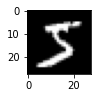

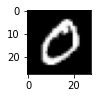

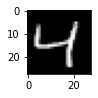

array([5, 0, 4], dtype=uint8)

In [6]:
for i in range(3):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()
    
train_y[:3]

## Train a simple model

In [7]:
train_X = train_X.astype('float32') / 255.0
valid_X = valid_X.astype('float32') / 255.0

In [8]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

2022-03-10 12:30:06.595802: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(train_X, train_y, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
8/8 [==============================] - 0s 2ms/step - loss: 2.0406 - accuracy: 0.3211
Epoch 2/10
8/8 [==============================] - 0s 2ms/step - loss: 1.4088 - accuracy: 0.7056
Epoch 3/10
8/8 [==============================] - 0s 2ms/step - loss: 1.0201 - accuracy: 0.7867
Epoch 4/10
8/8 [==============================] - 0s 2ms/step - loss: 0.8055 - accuracy: 0.8200
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.6684 - accuracy: 0.8267
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.5727 - accuracy: 0.8578
Epoch 7/10
8/8 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.8633
Epoch 8/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4814 - accuracy: 0.8589
Epoch 9/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4399 - accuracy: 0.8867
Epoch 10/10
8/8 [==============================] - 0s 2ms/step - loss: 0.4081 - accuracy: 0.8933


In [11]:
model.evaluate(valid_X, valid_y, verbose=1)

4/4 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.8800


[0.5253971815109253, 0.8799999952316284]

# Log models with MLFlow

In [12]:
%pip install -q mlflow

Note: you may need to restart the kernel to use updated packages.


In [13]:
# %pip install -q mlflow[extras]

In [14]:
import mlflow

The uri of the server is given at the `docker_compose.yml` file: `container_name: mlflow_server`

In [15]:
remote_server_uri = "http://mlflow_server:5000"

In [16]:
# I have been unable to use the MLFlow proxied artifact storage access for scenario 5 :(

PROXY_ARTIFACTS = False

The config below requires to setup boto3 and configure credentials for the MLFlow client (this notebook)

It represents this scenario: https://www.mlflow.org/docs/latest/tracking.html#scenario-4-mlflow-with-remote-tracking-server-backend-and-artifact-stores

It doesn't require to set up mlflow server with --serve-artifacts

In [18]:
if not PROXY_ARTIFACTS:
    %pip install -q boto3
    mlflow.set_tracking_uri(remote_server_uri)
    # mlflow.set_registry_uri('mlflow-artifacts:/')
    mlflow.set_experiment("simple-keras")

Note: you may need to restart the kernel to use updated packages.


In [19]:
# not sure if this is correct or not
if PROXY_ARTIFACTS:
    mlflow.set_tracking_uri(remote_server_uri)
    # mlflow.set_registry_uri('mlflow-artifacts:/')
    mlflow.set_experiment("simple-keras")

## Notes:

Starting a server with the --serve-artifacts flag enables proxied access for artifacts. The uri mlflow-artifacts:/ replaces an otherwise explicit object store destination (e.g., “s3:/my_bucket/mlartifacts”) for interfacing with artifacts. The client can access artifacts via HTTP requests to the MLflow Tracking Server. This simplifies access requirements for users of the MLflow client, eliminating the need to configure access tokens or username and password environment variables for the underlying object store when writing or retrieving artifacts.

In [20]:
import mlflow.keras

# Enable auto-logging to MLflow to capture TensorBoard metrics.
mlflow.tensorflow.autolog()

In [21]:
with mlflow.start_run():
    
    mlflow.log_artifact(os.path.join(DATA_DIR, SAMPLE_1000))
    mlflow.log_artifact(os.path.join(DATA_DIR, SAMPLE_1000_LABELS))

    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # fit the model
    model.fit(train_X, train_y, epochs=15, batch_size=128, verbose=1)

Epoch 1/15
8/8 [==============================] - 0s 7ms/step - loss: 2.1446 - accuracy: 0.2667
Epoch 2/15
8/8 [==============================] - 0s 2ms/step - loss: 1.4856 - accuracy: 0.6811
Epoch 3/15
8/8 [==============================] - 0s 2ms/step - loss: 1.0838 - accuracy: 0.7722
Epoch 4/15
8/8 [==============================] - 0s 2ms/step - loss: 0.8515 - accuracy: 0.8111
Epoch 5/15
8/8 [==============================] - 0s 2ms/step - loss: 0.6967 - accuracy: 0.8267
Epoch 6/15
8/8 [==============================] - 0s 2ms/step - loss: 0.5936 - accuracy: 0.8533
Epoch 7/15
8/8 [==============================] - 0s 2ms/step - loss: 0.5386 - accuracy: 0.8556
Epoch 8/15
8/8 [==============================] - 0s 2ms/step - loss: 0.4774 - accuracy: 0.8800
Epoch 9/15
8/8 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.8867
Epoch 10/15
8/8 [==============================] - 0s 2ms/step - loss: 0.4047 - accuracy: 0.8978
Epoch 11/15
8/8 [======================

2022-03-10 12:31:24.042752: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp2z71b7tw/model/data/model/assets


In [22]:
model.evaluate(valid_X, valid_y, verbose=1)

4/4 [==============================] - 0s 1ms/step - loss: 0.4740 - accuracy: 0.9000


[0.4739953875541687, 0.8999999761581421]

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(valid_X, valid_y), verbose=1)

2022/03/10 12:31:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ae1ef212cfa6457493c58a4161b87b40', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
15/15 [==============================] - 0s 10ms/step - loss: 1.9130 - accuracy: 0.4433 - val_loss: 1.3752 - val_accuracy: 0.7400
Epoch 2/10
15/15 [==============================] - 0s 3ms/step - loss: 1.0556 - accuracy: 0.7533 - val_loss: 0.8765 - val_accuracy: 0.8300
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.7024 - accuracy: 0.8267 - val_loss: 0.6996 - val_accuracy: 0.8500
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.5580 - accuracy: 0.8656 - val_loss: 0.5754 - val_accuracy: 0.8700
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4533 - accuracy: 0.8867 - val_loss: 0.5319 - val_accuracy: 0.8800
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4068 - accuracy: 0.8989 - val_loss: 0.4901 - val_accuracy: 0.9000
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3366 - accuracy: 0.9189 - val_loss: 0.4911 - val_accuracy: 0.8900
Epoch 8/10
15/15 [=

In [24]:
mlflow.tensorflow.autolog(disable=True)

Next model is not recorded

In [27]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, activation='relu'),    
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit the model
model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(valid_X, valid_y), verbose=1)

Epoch 1/10
15/15 [==============================] - 0s 7ms/step - loss: 2.0456 - accuracy: 0.3411 - val_loss: 1.5998 - val_accuracy: 0.6600
Epoch 2/10
15/15 [==============================] - 0s 2ms/step - loss: 1.3257 - accuracy: 0.6444 - val_loss: 0.9685 - val_accuracy: 0.7500
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.8503 - accuracy: 0.7622 - val_loss: 0.6806 - val_accuracy: 0.8100
Epoch 4/10
15/15 [==============================] - 0s 3ms/step - loss: 0.6306 - accuracy: 0.8144 - val_loss: 0.6001 - val_accuracy: 0.7800
Epoch 5/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4989 - accuracy: 0.8600 - val_loss: 0.4947 - val_accuracy: 0.8800
Epoch 6/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4219 - accuracy: 0.8822 - val_loss: 0.4750 - val_accuracy: 0.8900
Epoch 7/10
15/15 [==============================] - 0s 2ms/step - loss: 0.3653 - accuracy: 0.8911 - val_loss: 0.4334 - val_accuracy: 0.8900
Epoch 8/10
15/15 [==

In [27]:
runs_df = mlflow.search_runs(filter_string="metrics.accuracy > 0.5")
runs_df

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.loss,metrics.val_accuracy,metrics.accuracy,metrics.val_loss,...,params.initial_epoch,params.use_multiprocessing,params.validation_freq,params.validation_split,params.opt_name,tags.mlflow.autologging,tags.mlflow.source.type,tags.mlflow.source.name,tags.mlflow.user,tags.mlflow.log-model.history
0,ae1ef212cfa6457493c58a4161b87b40,3,FINISHED,s3://digits-recognizer-project/experiments/3/a...,2022-03-10 12:31:38.136000+00:00,2022-03-10 12:31:58.646000+00:00,0.251724,0.91,0.941111,0.425701,...,0,False,1,0.0,Adam,tensorflow,LOCAL,/opt/conda/lib/python3.9/site-packages/ipykern...,jovyan,"[{""run_id"": ""ae1ef212cfa6457493c58a4161b87b40""..."
1,107d4c95893241c4a22397f3b7f8b3b0,3,FINISHED,s3://digits-recognizer-project/experiments/3/1...,2022-03-10 12:31:13.243000+00:00,2022-03-10 12:31:37.995000+00:00,0.283735,NaN,0.925556,NaN,...,0,False,1,0.0,Adam,None,LOCAL,/opt/conda/lib/python3.9/site-packages/ipykern...,jovyan,"[{""run_id"": ""107d4c95893241c4a22397f3b7f8b3b0""..."


In [30]:
run_id = runs_df.loc[runs_df['metrics.accuracy'].idxmax()]['run_id']

In [31]:
run_id

'ae1ef212cfa6457493c58a4161b87b40'

In [32]:
result = mlflow.register_model(
    f"runs:/{run_id}",
    "keras-digits-model-1"
)

Successfully registered model 'keras-digits-model-1'.
2022/03/10 12:50:14 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: keras-digits-model-1, version 1
Created version '1' of model 'keras-digits-model-1'.
